A monte carlo implementation consists of the following parts:
1. A data structure that holds the configuration of the system
2. Code to suggest a new configuration by modifying the data structure
3. Code to accept/reject the move
4. Code to measure and store macroproperties(like energy, magnetization, etc)
5. Code to find and store averages, histograms, correlations, etc.

In [1]:
using Gadfly

In [2]:
#wb_len = 20 ;# waitbar length
#n_iter = 1000 ;
@everywhere function waitbar(wb_len, n_iter,i,update_iter)
  if mod(i,update_iter) == 0
   flush(STDOUT)
    print('\r')
   
    wb = "["
  
    for j = 1: wb_len
        if (j <= (convert(Int64,floor(wb_len*i/n_iter) )))
           wb= wb*"="
            
        else
            wb =  wb*" "
        end
         
    end
  wb = wb * "] "
  wb = wb * @sprintf("%.2f%%", 100*i/n_iter)
    #flush(STDOUT)
        print(wb)
   #sleep(0.1)
    end

end

In [3]:
@everywhere function M_init(grid)
    M = sum(grid)
    return M
end

In [4]:
@everywhere function E_init(grid,J)
    
    sumofneighbors=circshift(grid,[0 1])+
    circshift(grid,[0 -1])+
    circshift(grid,[1 0])+
    circshift(grid,[-1 0])
   
    E = 0.5 * sum(-J * grid .* sumofneighbors)
    
    return E
end

In [5]:
@everywhere function DelE(grid, J , row, col)
    
    neighbors = Neighbors(row,col,n_grid,grid)
    dE = 2*(J*grid[row,col]*neighbors)
    return dE
end

In [6]:
@everywhere function DelM(grid, J , row, col)
    if grid[row,col]==+1
        dM = -2
    elseif grid[row,col]==-1
        dM = +2
    end
    return dM
end

In [7]:
@everywhere function grid_init(n_grid, J)
    grid = 2*round.(rand(n_grid,n_grid))-ones(n_grid,n_grid)
    E = E_init(grid , J)
    M = M_init(grid)
    return grid, E , M
end

In [8]:
@everywhere function Propose_move(grid, n_grid,J)
    row = rand(1:n_grid)
    col = rand(1:n_grid)
    
    dE = DelE(grid, J ,  row, col)
    dM = DelM(grid, J , row, col)
    return row, col, dE , dM
end

In [9]:
@everywhere function Neighbors(row,col,n_grid,grid)
    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end
    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]
    return neighbors
end

In [10]:
@everywhere function MeshGrid(vector1,vector2)
    matrix2 = broadcast(+,vector2,zeros(length(vector1),length(vector2)))
    matrix1 = broadcast(+,vector1,zeros(length(vector2),length(vector1)))
    matrix2 = transpose(matrix2)
    return matrix1, matrix2
end

In [11]:
@everywhere function trial_list_init(n_equil)
    m_list = 1:1:n_equil ; 
    m_list = collect(m_list) ;
    e_list =  1:1:n_equil ;  
    e_list = collect(e_list); 
    m_list = [m_list  zeros(length(m_list),1) ]  ;
    e_list = [ e_list zeros(length(e_list),1) ] ;
    return m_list, e_list
end

In [12]:
@everywhere function trial_list_update(iter_no,M,E,m_list,e_list)
    iter_no = convert(Int64,iter_no)
    m_list[iter_no ,2] = M ;
    e_list[iter_no,2] = E ;
    return m_list,e_list
end

In [13]:
@everywhere function Ising_equil(T , J , n_grid , n_equil)
    grid,E,M = grid_init(n_grid, J)
    m_list, e_list = trial_list_init(n_equil)
    
    for iter_no in 1:n_equil
        waitbar(40, n_equil,iter_no,1e5)
        row, col, dE , dM  = Propose_move(grid,n_grid,J)
        Enew = E + dE
        Mnew = M + dM
        
        bias = 1
        # unbiased acceptance Probability
        acc_prob_ub = exp(-dE/T) 
        acc_prob = bias*acc_prob_ub
        acc_prob = min(1,acc_prob)
        acc_rand = rand(1)
        if acc_rand[1,1] <= acc_prob
            E = Enew
            M = Mnew
            grid[row,col] = -grid[row,col]
        end
        m_list, e_list = trial_list_update(iter_no,M,E,m_list,e_list)
        
    end
    return grid, E , M, m_list, e_list
end

# INPUTS

In [14]:
T = 2.5 ;
n_equil = 1e6 ;
n_prod = 1e7 ;
J = 1 ;
n_grid = 50 ;


# EQUILIBRIATION

In [15]:
@time grid,E,M, m_list, e_list = Ising_equil(T , J , n_grid , n_equil)

[========================================] 100.00%  2.122826 seconds (16.81 M allocations: 454.372 MiB, 6.11% gc time)


([-1.0 1.0 … -1.0 -1.0; -1.0 1.0 … -1.0 -1.0; … ; 1.0 -1.0 … 1.0 1.0; 1.0 1.0 … -1.0 -1.0], -2788.0, -312.0, [1.0 4.0; 2.0 4.0; … ; 999999.0 -310.0; 1.0e6 -312.0], [1.0 8.0; 2.0 8.0; … ; 999999.0 -2780.0; 1.0e6 -2788.0])

In [16]:
#=using Gadfly
plt1=plot(x=m_list[:,1],y=m_list[:,2],Guide.xlabel("Temp"),Guide.ylabel("Magnetisation/site"))
plt2=plot(x=e_list[:,1],y=e_list[:,2],Guide.xlabel("Temp"),Guide.ylabel("Susceptibility/site"))
display(plt1)
display(plt2)=#

In [17]:
@everywhere function hist_init(n_grid)
    m_hist = -(n_grid^2):2:(n_grid^2) ; 
    m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; 
    e_hist = collect(e_hist); 
    m_hist_grid,e_hist_grid = MeshGrid(transpose(m_hist),transpose(e_hist)) ;
    me_hist = [  m_hist_grid[:]  e_hist_grid[:] ] ;
    me_hist = [me_hist zeros(length(me_hist[:,2]),1)] ;
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ;
    e_hist = [ e_hist zeros(length(e_hist),1) ] ;
    return m_hist, e_hist, me_hist
end

In [18]:
@everywhere function hist_update(n_grid,M,E,m_hist,e_hist,me_hist)
    m_index = convert(Int64,((M + n_grid^2)/2) + 1) ;
    e_index = convert(Int64,((E + 2*(n_grid^2)))/4 + 1) ;
    m_hist[m_index ,2] += 1 ;
    e_hist[e_index,2] += 1 ;
    me_index = (m_index - 1) * length(e_hist[:,1]) + e_index ;
    me_hist[me_index,3] += 1 ;
    
    return m_hist,e_hist, me_hist
end

In [19]:
@everywhere function Ising_prod_hist(T , J , grid, E, M , n_grid , n_prod)
    m_hist, e_hist, me_hist = hist_init(n_grid)
    for iter_no in 1:n_prod
        waitbar(40, n_prod,iter_no,1e6)
        row, col, dE , dM  = Propose_move(grid,n_grid,J)
        Enew = E + dE
        Mnew = M + dM
        
        bias = 1
        # unbiased acceptance Probability
        acc_prob_ub = exp(-dE/T) 
        acc_prob = bias*acc_prob_ub
        acc_prob = min(1,acc_prob)
        acc_rand = rand(1)
        if acc_rand[1,1] <= acc_prob
            E = Enew
            M = Mnew
            grid[row,col] = -grid[row,col]
        end
        m_hist,e_hist,me_hist = hist_update(n_grid,M,E,m_hist,e_hist, me_hist)
        
    end
    return grid, m_hist, e_hist,me_hist, M, E
end

# HISTOGRAM COLLECTION PRODUCTION RUN 

In [20]:
@time grid, m_hist, e_hist, me_hist, M, E = Ising_prod_hist(T , J , grid , E, M , n_grid , n_prod);

[========================================] 100.00% 97.685853 seconds (200.21 M allocations: 191.845 GiB, 24.90% gc time)


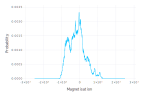

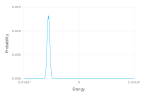

In [21]:
using Gadfly
plt1=plot(x=m_hist[:,1],y=m_hist[:,2]./n_prod,Geom.line,Guide.xlabel("Magnetisation"),Guide.ylabel("Probability"))
plt2=plot(x=e_hist[:,1],y=e_hist[:,2]./n_prod,Geom.line,Guide.xlabel("Energy"),Guide.ylabel("Probability"))
display(plt1)
display(plt2)

In [22]:
me_hist_log = copy(me_hist)
me_hist_log[find(me_hist_log[:,3]),3] = log.(me_hist_log[find(me_hist_log[:,3]),3])
me_hist_plotmat=reshape(me_hist[:,3],n_grid^2+1,n_grid^2+1)
plot(z=me_hist_plotmat',x=m_hist[:,1],y=e_hist[:,1], Geom.contour(levels=20))

InexactError: [91mInexactError()[39m

In [23]:
@everywhere function Tm_init(m_hist,e_hist,me_hist)
     m_tm = [m_hist zeros(length(m_hist[:,1]),2)];
     e_tm = [e_hist zeros(length(e_hist[:,1]),5)];
     me_tm = [me_hist zeros(length(me_hist[:,1]),10)] ;
    return m_tm, e_tm, me_tm
end

In [24]:
@everywhere function transition_ind(dE, dM)
        if dE == -8 && dM == -2 
                         me_change_index = 4; m_change_index = 4; e_change_index = 6
        elseif dE == -8  && dM == 2
                          me_change_index = 5; m_change_index = 3; e_change_index = 6
        elseif dE == -4  && dM == -2
                           me_change_index = 6; m_change_index = 4; e_change_index = 5
        elseif dE == -4  && dM == 2 
                          me_change_index = 7; m_change_index = 3; e_change_index = 5
        elseif dE == 0  && dM == -2 
                          me_change_index = 8; m_change_index = 4; e_change_index = 7
        elseif dE == 0  && dM == 2
                           me_change_index = 9; m_change_index = 3; e_change_index = 7
        elseif dE == 4  && dM == -2
                           me_change_index = 10; m_change_index = 4; e_change_index = 3
        elseif dE == 4  && dM == 2
                            me_change_index = 11; m_change_index = 3; e_change_index = 3
        elseif dE == 8  && dM == -2 
                            me_change_index = 12; m_change_index = 4; e_change_index = 4
        elseif dE == 8  && dM == 2 
                            me_change_index = 13; m_change_index = 3; e_change_index = 4
        else print("\n",dE,"\n",dM,"\n")
        end
    return me_change_index, m_change_index, e_change_index
end

In [25]:
@everywhere function Tm_update(n_grid, M , E , dM, dE, acc_prob, m_tm, e_tm, me_tm)
     m_index = convert(Int64,((M + n_grid^2)/2) + 1) ;
     e_index = convert(Int64,((E + 2*(n_grid^2)))/4 + 1) ;
     me_index = (m_index - 1) * length(e_hist[:,1]) + e_index ;
     me_change_index, m_change_index, e_change_index = transition_ind(dE,dM)
     
     m_tm[m_index,m_change_index] += acc_prob
     e_tm[e_index,e_change_index] += acc_prob
     me_tm[me_index,me_change_index] += acc_prob
    
     m_tm[m_index,2] += 1
     e_tm[e_index,2] += 1
     me_tm[me_index,3] += 1
     
    
     return m_tm, e_tm, me_tm
    
end

In [26]:
@everywhere function Tm_normalize(m_tm, e_tm, me_tm)
    me_tmn = copy(me_tm); m_tmn = copy(m_tm); e_tmn = copy(e_tm)
    me_tmn[find(me_tmn[:,3]),4:13] = me_tmn[find(me_tmn[:,3]), 4:13] ./ me_tmn[find(me_tmn[:,3]), 3] ;
    m_tmn[find(m_tmn[:,2]),3:4] = m_tmn[find(m_tmn[:,2]), 3:4] ./ m_tmn[find(m_tmn[:,2]), 2] ;
    e_tmn[find(e_tmn[:,2]),3:7] = e_tmn[find(e_tmn[:,2]), 3:7] ./ e_tmn[find(e_tmn[:,2]), 2] ;
    return m_tmn,e_tmn,me_tmn
end

In [27]:
@everywhere function Ising_prod_tm(T , J , grid, E, M , n_grid , n_prod)
    m_hist, e_hist, me_hist = hist_init(n_grid)
    m_tm, e_tm, me_tm = Tm_init(m_hist,e_hist,me_hist)
    
    for iter_no in 1:n_prod
        waitbar(50, n_prod,iter_no,1e6)
        row, col, dE , dM  = Propose_move(grid,n_grid,J)
        Enew = E + dE
        Mnew = M + dM
        
        bias = 1
        # unbiased acceptance Probability
        acc_prob_ub = exp(-dE/T) 
        acc_prob = bias*acc_prob_ub
        acc_prob = min(1,acc_prob)
        acc_prob_ub = min(1,acc_prob_ub)
        
        m_tm, e_tm, me_tm = Tm_update(n_grid, M , E , dM, dE, acc_prob_ub, m_tm, e_tm, me_tm)
        
        acc_rand = rand(1)
        if acc_rand[1,1] <= acc_prob
            E = Enew
            M = Mnew
            grid[row,col] = -grid[row,col]
        end
        m_hist,e_hist,me_hist = hist_update(n_grid,M,E,m_hist,e_hist, me_hist)
        
    end
    return grid, m_hist, e_hist,me_hist, M, E, m_tm, e_tm, me_tm
end

# TRANSITION MATRIX COLLECTION PRODUCTION RUN

In [28]:
@time grid, m_hist, e_hist,me_hist, M, E, m_tm, e_tm, me_tm = Ising_prod_tm(T , J , grid, E, M , n_grid , n_prod)

[==================================================] 100.00%171.538343 seconds (359.61 M allocations: 382.492 GiB, 28.26% gc time)


([1.0 1.0 … 1.0 1.0; 1.0 1.0 … -1.0 -1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … -1.0 -1.0], [-2500.0 0.0; -2498.0 0.0; … ; 2498.0 0.0; 2500.0 0.0], [-5000.0 0.0; -4996.0 0.0; … ; 4996.0 0.0; 5000.0 0.0], [-2500.0 -5000.0 0.0; -2500.0 -4996.0 0.0; … ; 2500.0 4996.0 0.0; 2500.0 5000.0 0.0], 680.0, -2768.0, [-2500.0 0.0 0.0 0.0; -2498.0 0.0 0.0 0.0; … ; 2498.0 0.0 0.0 0.0; 2500.0 0.0 0.0 0.0], [-5000.0 0.0 … 0.0 0.0; -4996.0 0.0 … 0.0 0.0; … ; 4996.0 0.0 … 0.0 0.0; 5000.0 0.0 … 0.0 0.0], [-2500.0 -5000.0 … 0.0 0.0; -2500.0 -4996.0 … 0.0 0.0; … ; 2500.0 4996.0 … 0.0 0.0; 2500.0 5000.0 … 0.0 0.0])

In [29]:
@time m_tmn,e_tmn,me_tmn = Tm_normalize(m_tm, e_tm, me_tm)

  0.704986 seconds (141.31 k allocations: 790.526 MiB, 18.07% gc time)


([-2500.0 0.0 0.0 0.0; -2498.0 0.0 0.0 0.0; … ; 2498.0 0.0 0.0 0.0; 2500.0 0.0 0.0 0.0], [-5000.0 0.0 … 0.0 0.0; -4996.0 0.0 … 0.0 0.0; … ; 4996.0 0.0 … 0.0 0.0; 5000.0 0.0 … 0.0 0.0], [-2500.0 -5000.0 … 0.0 0.0; -2500.0 -4996.0 … 0.0 0.0; … ; 2500.0 4996.0 … 0.0 0.0; 2500.0 5000.0 … 0.0 0.0])

# OPTIMIZATION FOR 2D TM HISTOGRAM

In [215]:
@everywhere function me_tm_var(me_tm, me_tmn, me_tm_hist, init_ind, fin_ind, n_grid)
   if fin_ind > 0 && fin_ind <= (n_grid^2+1)^2  
        
        
        dE = me_tm[fin_ind,2] - me_tm[init_ind,2] ;
        dM = me_tm[fin_ind,1] - me_tm[init_ind,1] ;
        #print(dE,"\n",dM)
        
    
        init_transition_ind,a,b = transition_ind(dE, dM) ;
        fin_transition_ind,a,b = transition_ind(- dE, - dM);
        
        if me_tm[init_ind,init_transition_ind]!=0 && me_tm[init_ind, 3]!=0  &&
        me_tm[fin_ind,fin_transition_ind]!=0  &&  me_tm[fin_ind,3]!=0
    
            sig = me_tm[init_ind,init_transition_ind]^-1 + me_tm[init_ind, 3]^-1 +
                me_tm[fin_ind,fin_transition_ind]^-1 + me_tm[fin_ind,3]^-1
    
    
            tm_var = ( log(me_tm_hist[init_ind]) - log(me_tm_hist[fin_ind]) + 
                log(me_tmn[init_ind, init_transition_ind]/me_tmn[fin_ind , fin_transition_ind])  ) ^ 2;
            #print(tm_var)
            tm_var = tm_var / sig ;
        else
            tm_var = 0 ;
        end
    else
        tm_var = 0 ;
    end
    return tm_var
end

In [216]:
@everywhere function me_tm_var_gross(me_tm, me_tmn, me_tm_hist,n_grid)
    tm_var = 0 ;
    for init_ind in 1:(n_grid^2+1)^2
        if mod(init_ind ,n_grid^2+1) != n_grid^2 && mod(init_ind ,n_grid^2+1) != 0
            fin_ind = init_ind + n_grid^2 + 3
             tm_var += me_tm_var(me_tm, me_tmn, me_tm_hist, init_ind, fin_ind, n_grid)
        end
        
            fin_ind = init_ind + n_grid^2 + 1
             tm_var += me_tm_var(me_tm, me_tmn, me_tm_hist, init_ind, fin_ind, n_grid)
        
        if mod(init_ind  ,n_grid^2+1) != 0
           fin_ind = init_ind + n_grid^2 + 2
             tm_var += me_tm_var(me_tm, me_tmn, me_tm_hist, init_ind, fin_ind, n_grid)
        end
          #  waitbar(60, (n_grid^2+1)^2,init_ind,4)
        
    end
    return tm_var
end    


In [217]:
@everywhere function optim_object(me_tm_hist)
    tm_var = me_tm_var_gross(me_tm, me_tmn, me_tm_hist,n_grid)
    return tm_var
    
end

In [218]:
using Optim
@time dd_me_tm_hist =optimize(optim_object, me_hist[:,3],NelderMead(),Optim.Options(g_tol=1e-8,iterations = 1000000))

 16.297415 seconds (324.48 M allocations: 4.850 GiB, 1.97% gc time)


Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [1.7179702e7,0.0, ...]
 * Minimizer: [1.7207006658647943e7,0.006991917289509612, ...]
 * Minimum: 3.284617e+01
 * Iterations: 167854
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 181325

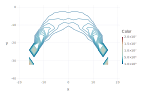

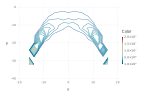

In [219]:

me_hist_log = copy(me_hist)
me_hist_plotmat=reshape(me_hist[:,3],n_grid^2+1,n_grid^2+1)
plot1=plot(z=me_hist_plotmat',x=m_hist[:,1],y=e_hist[:,1], Geom.contour(levels=50))

me_tm_hist = Optim.minimizer(dd_me_tm_hist)
me_hist_plotmat=reshape((me_tm_hist),n_grid^2+1,n_grid^2+1)
plot2=plot(z=me_hist_plotmat',x=m_hist[:,1],y=e_hist[:,1], Geom.contour(levels=50))

display(plot1)
display(plot2)

In [220]:
@everywhere function me_tm_var(me_tm, me_tmn, me_tm_hist_log, init_ind, fin_ind, n_grid)
   if fin_ind > 0 && fin_ind <= (n_grid^2+1)^2  
        
        
        dE = me_tm[fin_ind,2] - me_tm[init_ind,2] ;
        dM = me_tm[fin_ind,1] - me_tm[init_ind,1] ;
        #print(dE,"\n",dM)
        
    
        init_transition_ind,a,b = transition_ind(dE, dM) ;
        fin_transition_ind,a,b = transition_ind(- dE, - dM);
        
        if me_tm[init_ind,init_transition_ind]!=0 && me_tm[init_ind, 3]!=0  &&
        me_tm[fin_ind,fin_transition_ind]!=0  &&  me_tm[fin_ind,3]!=0
    
            sig = me_tm[init_ind,init_transition_ind]^-1 + me_tm[init_ind, 3]^-1 +
                me_tm[fin_ind,fin_transition_ind]^-1 + me_tm[fin_ind,3]^-1
    
    
            tm_var = ( me_tm_hist_log[init_ind] - me_tm_hist_log[fin_ind] + 
                log(me_tmn[init_ind, init_transition_ind]/me_tmn[fin_ind , fin_transition_ind])  ) ^ 2;
            #print(tm_var)
            tm_var = tm_var / sig ;
        else
            tm_var = 0 ;
        end
    else
        tm_var = 0 ;
    end
    return tm_var
end

In [221]:
@everywhere function me_tm_var_gross(me_tm, me_tmn, me_tm_hist_log,n_grid)
    tm_var = 0 ;
    for init_ind in 1:(n_grid^2+1)^2
        if mod(init_ind ,n_grid^2+1) != n_grid^2 && mod(init_ind ,n_grid^2+1) != 0
            fin_ind = init_ind + n_grid^2 + 3
             tm_var += me_tm_var(me_tm, me_tmn, me_tm_hist_log, init_ind, fin_ind, n_grid)
        end
        
            fin_ind = init_ind + n_grid^2 + 1
             tm_var += me_tm_var(me_tm, me_tmn, me_tm_hist_log, init_ind, fin_ind, n_grid)
        
        if mod(init_ind  ,n_grid^2+1) != 0
           fin_ind = init_ind + n_grid^2 + 2
             tm_var += me_tm_var(me_tm, me_tmn, me_tm_hist_log, init_ind, fin_ind, n_grid)
        end
            #waitbar(60, (n_grid^2+1)^2,init_ind,4)
        
    end
    return tm_var
end    


In [222]:
@everywhere function optim_object(me_tm_hist_log)
   # me_tm_hist_log = [me_tm[:,1:2] me_tm_hist_log]
    tm_var = me_tm_var_gross(me_tm, me_tmn, me_tm_hist_log,n_grid)
    return tm_var
    
end

In [223]:
me_tm_hist_log_init = copy(me_hist)
me_tm_hist_log_init[find(me_tm_hist_log_init[:,3]),3] = log.(me_tm_hist_log_init[find(me_tm_hist_log_init[:,3]),3])
@time optim_object(me_tm_hist_log_init[:,3])

  0.067192 seconds (29.59 k allocations: 1.441 MiB)


50.03558978711314

In [226]:
using Optim
@time dd_me_tm_hist =optimize(optim_object, me_tm_hist_log_init[:,3],NelderMead(),Optim.Options(g_tol=1e-8,iterations = 1000000))

 16.151058 seconds (316.97 M allocations: 4.736 GiB, 2.03% gc time)


Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [16.65923912861907,0.0, ...]
 * Minimizer: [16.660259450210056,0.018566857809253164, ...]
 * Minimum: 3.284617e+01
 * Iterations: 163971
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 177144

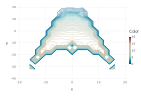

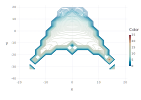

In [228]:

me_hist_log = copy(me_hist)
me_hist_log[find(me_hist_log[:,3]),3] = log.(me_hist_log[find(me_hist_log[:,3]),3])
me_hist_plotmat=reshape(me_hist_log[:,3],n_grid^2+1,n_grid^2+1)
plot1=plot(z=me_hist_plotmat',x=m_hist[:,1],y=e_hist[:,1], Geom.contour(levels=50))

me_tm_hist_log = Optim.minimizer(dd_me_tm_hist)
me_tm_hist_plotmat=reshape((me_tm_hist_log),n_grid^2+1,n_grid^2+1)
plot2=plot(z=me_tm_hist_plotmat',x=m_hist[:,1],y=e_hist[:,1], Geom.contour(levels=50))

display(plot1)
display(plot2)

# TRANSITION MATRIX FOR MAGNETIZATION IN SUB-GRIDS

In [55]:
@everywhere function Sub_grid_M_init(grid, n_grid, sub_grid_row, sub_grid_col , sub_grid_size)
    sub_grid = grid[sub_grid_row : sub_grid_row + sub_grid_size - 1, sub_grid_col : sub_grid_col + sub_grid_size - 1]
    sub_grid_M = sum(sub_grid)
    return sub_grid_M
end

In [56]:
@everywhere function Sub_grid_M_update(grid, n_grid, sub_grid_row, sub_grid_col, sub_grid_size, row, col, sub_grid_M, dM)
    if (row >= sub_grid_row && row <= sub_grid_row + sub_grid_size - 1 &&
        col >= sub_grid_col && col <= sub_grid_col + sub_grid_size - 1)
        sub_grid_M = sub_grid_M + dM
        dM_sub_grid = dM
    else
        dM_sub_grid = 0
    end
        return sub_grid_M, dM_sub_grid
end

In [57]:
@everywhere function Sub_grid_M_hist_init(sub_grid_size1, sub_grid_size2 )
    sub_grid_size1_list = collect(- sub_grid_size1 ^ 2 : 2 : sub_grid_size1 ^ 2)
    sub_grid_size2_list = collect(- sub_grid_size2 ^ 2 : 2 : sub_grid_size2 ^ 2)
    sub_grid_size1_grid,sub_grid_size2_grid = MeshGrid(transpose(sub_grid_size1_list),transpose(sub_grid_size2_list)) ;
    sub_grid_size12 = [  sub_grid_size1_grid[:]  sub_grid_size2_grid[:] ] ;
    sub_grid_hist12 = [sub_grid_size12 zeros(length(sub_grid_size12[:,2]),1)] ;
    return sub_grid_hist12
end

In [58]:
@everywhere function Sub_grid_M_tm_init(sub_grid_size1, sub_grid_size2 )
    sub_grid_size1_list = collect(- sub_grid_size1 ^ 2 : 2 : sub_grid_size1 ^ 2)
    sub_grid_size2_list = collect(- sub_grid_size2 ^ 2 : 2 : sub_grid_size2 ^ 2)
    sub_grid_size1_grid,sub_grid_size2_grid = MeshGrid(transpose(sub_grid_size1_list),transpose(sub_grid_size2_list)) ;
    sub_grid_size12 = [  sub_grid_size1_grid[:]  sub_grid_size2_grid[:] ] ;
    sub_grid_tm12 = [sub_grid_size12 zeros(length(sub_grid_size12[:,2]),6)] ;
    return sub_grid_tm12
end

In [59]:
@everywhere function Sub_grid_M_hist_update(dM1, dM2, M1, M2, sub_grid_size, sub_grid_hist12 )
    sub_grid_hist1_index = convert(Int64 , (M1 + sub_grid_size^2) / 2 + 1 )
    sub_grid_hist2_index = convert(Int64 , (M2 + sub_grid_size^2) / 2 + 1 )
    sub_grid_hist12_index = ( sub_grid_size^2 + 1 ) * ( sub_grid_hist1_index - 1 ) + sub_grid_hist2_index 
   if sub_grid_hist12_index <=1 || sub_grid_hist12_index > 4225
        print(M1,M2)
    end
    sub_grid_hist12[sub_grid_hist12_index, 3] = sub_grid_hist12[sub_grid_hist12_index, 3] + 1 
    return sub_grid_hist12
end

In [60]:
@everywhere function Sub_grid_M_tm_update(dM1, dM2, M1, M2, sub_grid_size, sub_grid_tm12 , acc_prob)
    sub_grid_tm1_index = convert(Int64 , (M1 + sub_grid_size^2) / 2 + 1 )
    sub_grid_tm2_index = convert(Int64 , (M2 + sub_grid_size^2) / 2 + 1 )
    sub_grid_tm12_index = ( sub_grid_size^2 + 1 ) * ( sub_grid_tm1_index - 1 ) + sub_grid_tm2_index 
    if dM1 == +2 && dM2 == 0
       sub_grid_tm12_change_index = 4
    elseif dM1 == -2 && dM2 == 0
        sub_grid_tm12_change_index = 5
    elseif dM1 == 0 && dM2 == +2
        sub_grid_tm12_change_index = 6
    elseif dM1 == 0 && dM2 == -2
        sub_grid_tm12_change_index = 7
    elseif dM1 == 0 && dM2 == 0
        sub_grid_tm12_change_index = 8
    end
    sub_grid_tm12[sub_grid_tm12_index, 3] = sub_grid_tm12[sub_grid_tm12_index, 3] + 1 
    sub_grid_tm12[sub_grid_tm12_index, sub_grid_tm12_change_index] =
          sub_grid_tm12[sub_grid_tm12_index, sub_grid_tm12_change_index] + acc_prob
    return sub_grid_tm12
end

In [61]:
@everywhere function Ising_prod_tm_bin_mag(T , J , grid, E, M , n_grid , n_prod, sub_grid_row1, sub_grid_col1, sub_grid_row2, sub_grid_col2, sub_grid_size )
    m_hist, e_hist, me_hist = hist_init(n_grid)
    m_tm, e_tm, me_tm = Tm_init(m_hist,e_hist,me_hist)
    M1 = Sub_grid_M_init(grid, n_grid, sub_grid_row1, sub_grid_col1 , sub_grid_size)
    M2 = Sub_grid_M_init(grid, n_grid, sub_grid_row2, sub_grid_col2 , sub_grid_size)
    sub_grid_hist12 = Sub_grid_M_hist_init(sub_grid_size, sub_grid_size )
    sub_grid_tm12 = Sub_grid_M_tm_init(sub_grid_size, sub_grid_size )
    
    for iter_no in 1:n_prod
        waitbar(50, n_prod,iter_no,1e5)
        row, col, dE , dM  = Propose_move(grid,n_grid,J)
        M1new, dM1 = Sub_grid_M_update(grid, n_grid, sub_grid_row1, sub_grid_col1, sub_grid_size, row, col, M1, dM)
        M2new, dM2 = Sub_grid_M_update(grid, n_grid, sub_grid_row2, sub_grid_col2, sub_grid_size, row, col, M2, dM)
        Enew = E + dE
        Mnew = M + dM
        
        bias = 1
        # unbiased acceptance Probability
        acc_prob_ub = exp(-dE/T) 
        acc_prob = bias*acc_prob_ub
        acc_prob = min(1,acc_prob)
        acc_prob_ub = min(1,acc_prob_ub)
        
        m_tm, e_tm, me_tm = Tm_update(n_grid, M , E , dM, dE, acc_prob_ub, m_tm, e_tm, me_tm)
        sub_grid_tm12 = Sub_grid_M_tm_update(dM1, dM2, M1, M2, sub_grid_size, sub_grid_tm12 , acc_prob_ub)
        
        acc_rand = rand(1)
        if acc_rand[1,1] <= acc_prob
            E = Enew
            M = Mnew
            grid[row,col] = -grid[row,col]
            M1 = M1new
            M2 = M2new
        end
        m_hist,e_hist,me_hist = hist_update(n_grid,M,E,m_hist,e_hist, me_hist)
        sub_grid_hist12 = Sub_grid_M_hist_update(dM1, dM2, M1, M2, sub_grid_size, sub_grid_hist12 )
        
    end
    return grid, m_hist, e_hist,me_hist, M, E, m_tm, e_tm, me_tm , sub_grid_hist12 , sub_grid_hist12
end

In [62]:
 sub_grid_row1 = 4 ;
sub_grid_col1= 4 ;
sub_grid_row2 = 14 ;
sub_grid_col2 = 14 ;
sub_grid_size = 8 ;

In [64]:
@time grid, m_hist, e_hist,me_hist, M, E, m_tm, e_tm, me_tm , sub_grid_hist12 , sub_grid_hist12 =
Ising_prod_tm_bin_mag(T , J , grid, E, M , n_grid , n_prod, sub_grid_row1, sub_grid_col1, sub_grid_row2, sub_grid_col2, sub_grid_size )

[==================================================] 100.00%144.973700 seconds (379.94 M allocations: 382.799 GiB, 29.31% gc time)


([-1.0 1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-2500.0 0.0; -2498.0 0.0; … ; 2498.0 0.0; 2500.0 0.0], [-5000.0 0.0; -4996.0 0.0; … ; 4996.0 0.0; 5000.0 0.0], [-2500.0 -5000.0 0.0; -2500.0 -4996.0 0.0; … ; 2500.0 4996.0 0.0; 2500.0 5000.0 0.0], -698.0, -2740.0, [-2500.0 0.0 0.0 0.0; -2498.0 0.0 0.0 0.0; … ; 2498.0 0.0 0.0 0.0; 2500.0 0.0 0.0 0.0], [-5000.0 0.0 … 0.0 0.0; -4996.0 0.0 … 0.0 0.0; … ; 4996.0 0.0 … 0.0 0.0; 5000.0 0.0 … 0.0 0.0], [-2500.0 -5000.0 … 0.0 0.0; -2500.0 -4996.0 … 0.0 0.0; … ; 2500.0 4996.0 … 0.0 0.0; 2500.0 5000.0 … 0.0 0.0], [-64.0 -64.0 0.0; -64.0 -62.0 0.0; … ; 64.0 62.0 0.0; 64.0 64.0 0.0], [-64.0 -64.0 0.0; -64.0 -62.0 0.0; … ; 64.0 62.0 0.0; 64.0 64.0 0.0])

In [65]:
me_hist_plotmat=reshape(sub_grid_hist12[:,3], sub_grid_size^2 +1, sub_grid_size^2 +1)
plot1=plot(z=me_hist_plotmat',x=sub_grid_hist12[1:65,1],y=sub_grid_hist12[1:65,1], Geom.contour(levels=50))


InexactError: [91mInexactError()[39m